
#### **Python & Qiskit Setup**

In [ ]:
# Setup básico
!pip install qiskit -q
!pip install qiskit[visualization] -q
import qiskit as qk

!pip install qiskit-aer -q
import qiskit_aer as qk_aer

import numpy as np
np.set_printoptions(precision=3, suppress=True)

from matplotlib import pyplot as plt
%matplotlib inline

import pandas as pd
import sklearn as sk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 26.9 MB/s eta 0:00:00


#### **Teleportation Circuit**

The Qiskit's representation for the first circuit to be analyzed is shown below. The circuit will not be simulated, because the teleportation can better be understood in algebraically terms.

Let's understand it symbolicaly. The equivalent circuit will transfer a qubit $|\psi\rangle = \alpha |0\rangle + \beta|1\rangle$ from qubit $|q_0\rangle$ (in Alice's lab) to qubit $|q_2\rangle$ (in Bob's lab).

The procedure goes as follows:

- Alice and Bob share an entangled qubit pair, one in Alice's ($|A\rangle$) and the other in Bob's ($|B\rangle$) lab.

- Alice will first perform a CNOT between the qubit $|\psi\rangle$ (as control) and her entangled qubit ($|A\rangle$) as target.

- Alice then apply a Hadamard gate in her original qubit (the one that is being moved) and measure both her qubits. She will get as a result 0 and 0, 0 and 1, 1 and 0 or 1 and 1. She them tells Bob (by telephone) what were her results.

- Depending on the information that Alice tells Bob, Bob will apply in his qubit one of the for operations: 1) (00) do nothing, 2) (01) a Z (phase flip) gate, 3) (10) a NOT gate or 4) (11) a Z and a NOT gate.

- We will show that by proceeding this way, in the end Bob will have in his lab a qubit equal to the one that Alice had. Keep in mind that Alice lost her qubit information when she measure it.

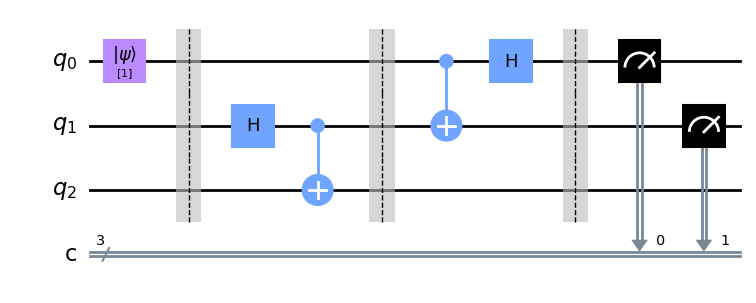

In [ ]:
import qiskit as qk
qc = qk.QuantumCircuit(3,3)
qc.initialize(1,[0])
qc.barrier()
qc.h(1)
qc.cx(1,2)
qc.barrier()
qc.cx(0,1)
qc.h(0)
qc.barrier()
qc.measure([0,1],[0,1])
display(qc.draw('mpl', style='clifford', scale=1))

Let's replicate the operations in matrix format using `sympy`. Instead of *kets* we will use *bras*. This will allow us to represent the matrix operations flowing from left to right

In [ ]:
import sympy as sp
a, b = sp.symbols('a b')
q0 = sp.Matrix([[a, b]]); display(q0); print(" ")
q1 = sp.Matrix([[1, 0]]); display(q1); print(" ")
q2 = sp.Matrix([[1, 0]]); display(q2);

Matrix([[a, b]])

Matrix([[1, 0]])

Matrix([[1, 0]])

In [ ]:
from sympy import kronecker_product as kron
e0 = kron(q0, kron(q1,q2)); e0

Matrix([[a, 0, 0, 0, b, 0, 0, 0]])

In [ ]:
I1 = sp.Matrix([[1,0],
                [0,1]])
H1 = sp.Matrix([[1, 1],
                [1,-1]])
IHI = kron(I1,kron(H1,I1))

CNOT12 = sp.Matrix([[1,0,0,0],
                    [0,1,0,0],
                    [0,0,0,1],
                    [0,0,1,0]])
IC12 = kron(I1,CNOT12)


e1 = e0*IHI*IC12; e1

Matrix([[a, 0, 0, a, b, 0, 0, b]])

In [ ]:
e2 = e1*kron(CNOT12,I1)*kron(H1,kron(I1,I1)); e2

Matrix([[a, b, b, a, a, -b, -b, a]])

Now let's at this last state more closely. As can be seen it was:

- final state: $\langle\psi_0| = \langle q_0 q_1 q_2| = a\langle 000| + b\langle001| + b\langle010| + a\langle011| + a\langle100| - b\langle101| - b\langle110| + a\langle111| $

$\langle00|[+a\langle 0| + b\langle 1|]  $ - Do Nothing

$\langle01|[+b\langle 0| + a\langle 1|]  $ - Apply X (NOT)

$\langle10|[+a\langle 0| - b\langle 1|]  $ - Apply Z (Phase flip)

$\langle11|[-b\langle 0| + a\langle 1|]  $ - Apply X.Z (NOT and Phase flip)
